<a href="https://colab.research.google.com/github/jurajhunak/Stroke_from_collab/blob/main/Stroke_classification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://www.kaggle.com/datasets/prosperchuks/health-dataset?select=stroke_data.csv

# Imports

## Instalations

In [38]:
!pip install pandas-profiling==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libraries

In [41]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [42]:
# Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [43]:
# metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [66]:
#Model tuning
from sklearn.model_selection import GridSearchCV

# Dataset

In [44]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDA Data Science Colab Notebooks/Kaggle/Diabetes, stroke, hypertension/archive/stroke_data.csv")

In [45]:
data.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [46]:
data.shape

(40910, 11)

## Data overview, pandas profiling

As we can see, this is a well prepared dataset with low/ almost no need for any preprocessing. Later, when we will want to improve chosen model performance, we might use some feature scaling techniques (like normalization, standardisation or similar). Let's call pandas profiling to better visualise and thus understand given dataset

In [47]:
profile = ProfileReport(data)

In [48]:
profile.to_file("Stroke_Classification_Dataset_fromKaggle.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

From this report, we can see that this dataset is quite balanced with almost no missing values. We can see few exceptions in categories:
- sex: 3 missing among 40,910; I would suggest to delete these rows
- age: 23 zeros, minimum value -9, which is obvious non-sense. I would suggest to delete all data with age below 0

We can visualise following categories below:

## Data preprocessing

### Age

(array([ 145., 1341., 3737., 5385., 6445., 7698., 6644., 5625., 3230.,
         660.]),
 array([ -9. ,   2.2,  13.4,  24.6,  35.8,  47. ,  58.2,  69.4,  80.6,
         91.8, 103. ]),
 <a list of 10 Patch objects>)

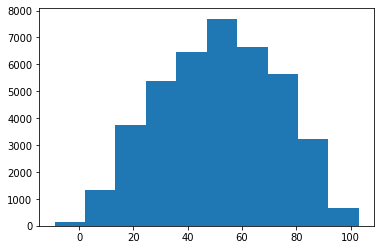

In [49]:
plt.hist(data.age)

In [50]:
data.age.min()

-9.0

In [51]:
data[data['age'] <= 0].shape

(81, 11)

In [52]:
# deleting them
data = data.drop(data.loc[data['age']<=0].index)

now, we have only 40,829 columns

In [53]:
data.shape

(40829, 11)

### Sex

(array([18172.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22654.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

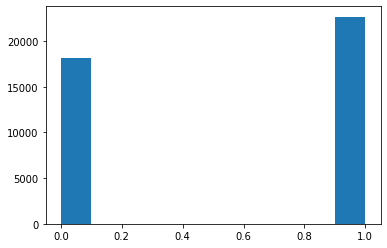

In [54]:
plt.hist(data.sex)

In [55]:
data.sex.unique()

array([ 1.,  0., nan])

In [56]:
#display missing values
data[(data.sex != 0) & (data.sex != 1)]

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
22478,NaN,39.0,0,0,1,4,1,70.56,28.6,1,0
28908,NaN,36.0,0,0,1,4,1,70.56,28.6,1,0
35184,NaN,77.0,0,0,1,4,1,70.56,28.6,1,0


In [57]:
# delete missing values
data = data.drop(data[(data.sex != 0) & (data.sex != 1)].index)

In [58]:
data.shape

(40826, 11)

  Now, shape of our data is smaller by 3 (deleted missing sex values)

# Targets to find out, validation metrics

This is a binary classification problem. We want to build a model, which predicts whether the patient suffered a stroke or not. For this purpose, we should use AUC-ROC score and confusion matrix as our validation metrics and focus on improving their scores. 

# Baseline model

I will use loop with various models to find out the best performing one. 

## X, y definition

In [59]:
X = data.drop(['stroke'], axis=1)
y = data.stroke

## Train, test split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=42)

## Models

In [61]:
model = [
    DecisionTreeClassifier(max_depth=3, criterion='entropy'),
    DecisionTreeClassifier(max_depth=3, criterion='gini'),
    RandomForestClassifier(n_estimators=3, criterion='entropy'),
    AdaBoostClassifier(n_estimators=3),
    GradientBoostingClassifier(n_estimators=3, max_depth=3),
    XGBClassifier(n_estimators=3, max_depth=3),
    CatBoostClassifier(silent=True),
    LGBMClassifier(n_estimators = 5, ),
    KNeighborsClassifier(),
]

### Training

In [62]:
#Do some preperation for the loop
col = []
algorithms = pd.DataFrame(columns = col)
idx = 0

#Train and score algorithms
for a in model:
    
    a.fit(X_train, y_train)
    y_pred = a.predict(X_test)
    acc_train = accuracy_score(y_train, a.predict(X_train)) #Other way: a.score(X_test, y_test)
    acc_test = accuracy_score(y_test, y_pred) #Other way: a.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred)
    cv = cross_val_score(a, X_test, y_test).mean()
    auc = roc_auc_score(y_test, y_pred)
    
    Alg = a.__class__.__name__
    
    algorithms.loc[idx, 'Algorithm'] = Alg
    algorithms.loc[idx, 'Accuracy [train]'] = round(acc_train * 100, 2)
    algorithms.loc[idx, 'Accuracy [test]'] = round(acc_test * 100, 2)
    algorithms.loc[idx, 'F1 Score'] = round(f1 * 100, 2)
    algorithms.loc[idx, 'CV Score'] = round(cv * 100, 2)
    algorithms.loc[idx, 'AUC Score'] = round(auc * 100, 2)

    idx+=1

### Overview

#### Scoring metrics

In [63]:
algorithms.sort_values(by='AUC Score', ascending=False)

,Algorithm,Accuracy [train],Accuracy [test],F1 Score,CV Score,AUC Score
6,CatBoostClassifier,99.91,99.81,99.81,97.67,99.81
2,RandomForestClassifier,99.81,98.78,98.79,94.49,98.78
7,LGBMClassifier,82.21,81.61,82.61,81.24,81.61
8,KNeighborsClassifier,87.43,81.09,83.36,69.48,81.09
4,GradientBoostingClassifier,69.64,69.25,65.82,68.80,69.25
5,XGBClassifier,69.64,69.25,65.82,68.37,69.25
3,AdaBoostClassifier,68.35,67.86,65.03,67.86,67.86
0,DecisionTreeClassifier,66.88,66.44,61.44,66.10,66.45
1,DecisionTreeClassifier,66.58,66.03,61.15,66.33,66.04


From these metrics, we can conclude that Catboost and Random forest are best algorithms for our task, with considerable better performance than other models. 

However, we should be careful to overfitting (accuracy scores are very high for train as well as test data). But on the other hand, test and train accuracies are not very distant from each other, what decreases the risk of overfitting.

#### Confusion matrix

In [64]:
true_positives = y_test[y_test==1]
true_positives.shape

(5105,)

In [65]:
print("Matrix displayed as follows:\nTN FP\nFN TP")
for b in model:

  name = b.__class__.__name__

  b.fit(X_train, y_train)
  y_pred_cmx = b.predict(X_test)
  cmx = confusion_matrix(y_test, y_pred_cmx)

  print(f"Algorithm: {name}\n", cmx)

Matrix displayed as follows:
TN FP
FN TP
Algorithm: DecisionTreeClassifier
 [[4053 1049]
 [2376 2729]]
Algorithm: DecisionTreeClassifier
 [[4011 1091]
 [2376 2729]]
Algorithm: RandomForestClassifier
 [[5008   94]
 [  16 5089]]
Algorithm: AdaBoostClassifier
 [[3875 1227]
 [2054 3051]]
Algorithm: GradientBoostingClassifier
 [[4045 1057]
 [2082 3023]]
Algorithm: XGBClassifier
 [[4045 1057]
 [2082 3023]]
Algorithm: CatBoostClassifier
 [[5083   19]
 [   0 5105]]
Algorithm: LGBMClassifier
 [[3872 1230]
 [ 647 4458]]
Algorithm: KNeighborsClassifier
 [[3441 1661]
 [ 269 4836]]


Looking at the confusion matrix, Catboost performs very well with only 19 false positives and 0 false negatives. 

RandomForest has also satisfactory results. 

As this is medical problem, great news is that our best performing models have low false negative rates. False negatives are big problems in this matter, becouse we might oversee patients who in reality need medical treatment/ preventive steps. 

# Feature Engineering

Because this dataset has been very balanced and well-prepared, I would not provide any feature engineering, feature selection or any other data processing technique (standardscaling, normalization, ...). 

Another reason for this decision is the fact, that both CatBoost and RandomForest already performed well with original input data.

# Model tuning

Now we will try GridSearch cross validation with Catboost and RandomForest

## Catboost Algorithm

In [67]:
param_grid = {
            'iterations':[100,500,1000],
            'learning_rate':[0.01,0.1,0.5],
            'depth':[3,6,10]
            }

In [68]:
grid_catboost = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

In [71]:
grid_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1587ed4af0>,
             n_jobs=-1,
             param_grid={'depth': [3, 6, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.1, 0.5]},
             verbose=1)

In [72]:
grid_catboost.best_params_

{'depth': 10, 'iterations': 500, 'learning_rate': 0.5}

## RandomForest Algorithm

In [82]:
param_grid_ranfor = {
    'n_estimators' : [1,3,5],
    'criterion' : ["gini", "entropy"],
    'min_samples_split' : [2, 3, 5],
    'min_samples_leaf' : [1, 2, 3]
}

In [83]:
grid_randomforest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_ranfor, cv=5, n_jobs=-1, verbose=1)

In [84]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [87]:
grid_randomforest.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [1, 3, 5]},
             verbose=1)

In [88]:
grid_randomforest.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 5}

In [90]:
result_gridsearchcv_randomforest = pd.DataFrame(grid_randomforest.cv_results_)

In [92]:
# result_gridsearchcv_randomforest